In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from transformers import BartForConditionalGeneration, BartTokenizer

# Load the model and tokenizer
model_path = "/content/drive/MyDrive/data-for-clinical-note-summarizer/fine_tuned_bio_bart"
model = BartForConditionalGeneration.from_pretrained(model_path)
tokenizer = BartTokenizer.from_pretrained(model_path)

print("Model and tokenizer loaded successfully.")


In [1]:
!pip install safetensors gdown


In [3]:
import gdown

# Replace FILE_ID with the actual file ID from your Google Drive link
gdown.download('https://drive.google.com/file/d/1-3hQPZ9DINLM3x_aBbDPBIeYyXRcLP9N/view?usp=sharing', 'model.safetensors', quiet=False)


Downloading...
From: https://drive.google.com/file/d/1-3hQPZ9DINLM3x_aBbDPBIeYyXRcLP9N/view?usp=sharing
To: /kaggle/working/model.safetensors
91.8kB [00:00, 3.84MB/s]


'model.safetensors'

In [ ]:
# Save the modified DataFrame to a new CSV file (optional)
output_file_path = "/content/cleaned_output_dropped.csv"
df.to_csv(output_file_path, index=False)


In [3]:
import pandas as pd

In [4]:
# Load dataset
data = pd.read_csv('/kaggle/input/pubmed/cleaned_output_dropped.csv')  
train_df, val_df, test_df = (
    data.sample(frac=0.8, random_state=42),
    data.sample(frac=0.1, random_state=42),
    data.sample(frac=0.1, random_state=42)
)



In [5]:
from datasets import Dataset, DatasetDict
# Convert to Hugging Face Dataset
def load_dataset(df):
    return Dataset.from_pandas(df[['abstract_cleaned', 'paragraphs_cleaned']])

datasets = DatasetDict({
    "train": load_dataset(train_df),
    "validation": load_dataset(val_df),
    "test": load_dataset(test_df)
})

In [6]:
data

,abstract_cleaned,paragraphs_cleaned
0,exosome complex 35 exoribonucleases rnabinding...,human exosome complex 35 exoribonuclease activ...
1,expression selenocysteine seccontaining protei...,selenocysteine seccontaining protein serve imp...
2,study show single intranasal dose plasmid enco...,recent development various murine model intest...
3,knotted protein commonly observed recent year ...,knotted protein become common recent year 114 ...
4,two collection oligonucleotides designed prepa...,microarray technology expression profiling may...
...,...,...
35359,backgroundaims capsule endoscopy ce used vario...,capsule endoscopy ce used various purpose aim ...
35360,background lselectin ligand localized luminal ...,lselectin ligand localized luminal epithelium ...
35361,survival antigenexperienced cell essential gen...,decision survival apoptosis cell particular im...
35362,circular dichroism cd spectroscopy essential t...,circular dichroism cd spectroscopy widely used...


In [1]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from transformers import TrainingArguments, Trainer


model_name = "GanjinZero/biobart-base"  
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)


tokenizer_config.json:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/279M [00:00<?, ?B/s]

In [7]:
# Tokenization
def preprocess_data(examples):
    inputs = tokenizer(
        examples['paragraphs_cleaned'], max_length=512, truncation=True, padding='max_length'
    )
    targets = tokenizer(
        examples['abstract_cleaned'], max_length=150, truncation=True, padding='max_length'
    )
    inputs['labels'] = targets['input_ids']
    return inputs

# Apply tokenization
tokenized_datasets = datasets.map(preprocess_data, batched=True, remove_columns=['paragraphs_cleaned', 'abstract_cleaned'])

# Data Collator
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model_name)


Map:   0%|          | 0/28291 [00:00<?, ? examples/s]

Map:   0%|          | 0/3536 [00:00<?, ? examples/s]

Map:   0%|          | 0/3536 [00:00<?, ? examples/s]

In [8]:
import torch
from transformers import TrainingArguments, Trainer

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure that the model is on the correct device
model = model.to(device)



In [9]:
print(device)

cuda


In [10]:
from transformers import Trainer

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./bio_bart_summarizer",  # Directory to save checkpoints
    evaluation_strategy="epoch",        # Evaluate after every epoch
    save_strategy="epoch",               # Save model checkpoints after every epoch
    logging_dir="./logs",                # Directory for logging
    logging_steps=50,                    # Log every 50 steps
    per_device_train_batch_size=8,      # Batch size for training
    per_device_eval_batch_size=8,       # Batch size for evaluation
    gradient_accumulation_steps=2,      # Accumulate gradients to simulate a larger batch size
    learning_rate=3e-5,                  # Learning rate
    num_train_epochs=20,                # Number of epochs
    weight_decay=0.01,                  # Weight decay for regularization
    save_total_limit=2,                 # Save only the last 2 checkpoints
    load_best_model_at_end=True,         # Load the best model at the end of training
    report_to=["none"],                  # Disable WandB logging if not needed
    fp16=True,                           # Enable mixed precision training for faster training and lower memory usage
    dataloader_num_workers=4,            # Number of subprocesses to use for data loading
    
)


# Trainer Initialization
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer
)

# Train the Model
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
0,2.778000,2.574113
2,2.603100,2.380080
4,2.434500,2.273106
6,2.428400,2.207037
8,2.345600,2.174011
9,2.342100,2.170057


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_eos_token_id': 2}
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Some non-default generation parameters are set in the model config. These sh

TrainOutput(global_step=8840, training_loss=2.50933350783128, metrics={'train_runtime': 17574.1551, 'train_samples_per_second': 16.098, 'train_steps_per_second': 0.503, 'total_flos': 8.620545507065856e+16, 'train_loss': 2.50933350783128, 'epoch': 9.994347088750708})

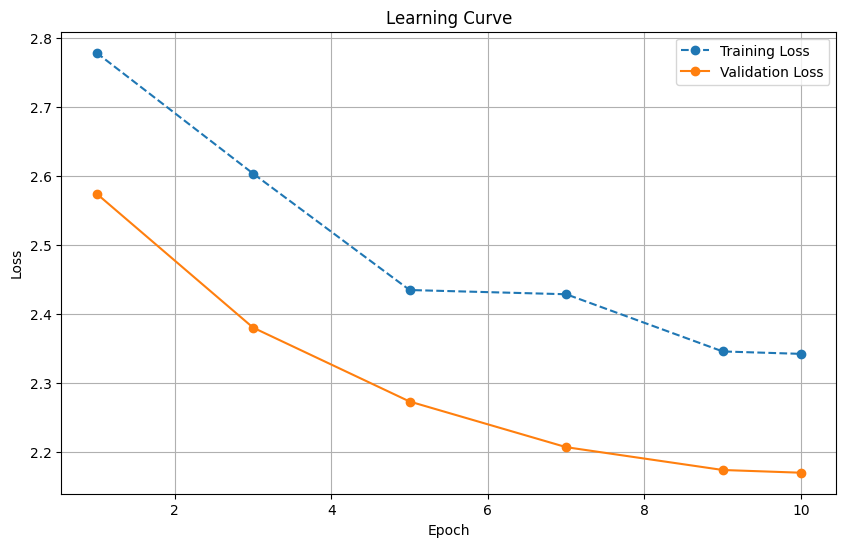

In [16]:
import matplotlib.pyplot as plt

# Data for the plot
epochs = [1, 3, 5, 7, 9, 10]
training_loss = [2.778000, 2.603100, 2.434500, 2.428400, 2.345600, 2.342100]
validation_loss = [2.574113, 2.380080, 2.273106, 2.207037, 2.174011, 2.170057]

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label="Training Loss", marker="o", linestyle="--")
plt.plot(epochs, validation_loss, label="Validation Loss", marker="o", linestyle="-")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.grid()
plt.show()


In [14]:
import matplotlib.pyplot as plt
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

# Define training arguments
training_args = TrainingArguments(
    output_dir="./bio_bart_summarizer",  # Directory to save checkpoints
    evaluation_strategy="epoch",        # Evaluate after every epoch
    save_strategy="epoch",               # Save model checkpoints after every epoch
    logging_dir="./logs",                # Directory for logging
    logging_steps=50,                    # Log every 50 steps
    per_device_train_batch_size=8,      # Batch size for training
    per_device_eval_batch_size=8,       # Batch size for evaluation
    gradient_accumulation_steps=2,      # Accumulate gradients to simulate a larger batch size
    learning_rate=3e-5,                 # Learning rate
    num_train_epochs=20,                # Number of epochs
    weight_decay=0.01,                  # Weight decay for regularization
    save_total_limit=2,                 # Save only the last 2 checkpoints
    load_best_model_at_end=True,        # Load the best model at the end of training
    report_to=["tensorboard"],                 # Disable WandB logging if not needed
    fp16=True,                          # Enable mixed precision training for faster training and lower memory usage
    dataloader_num_workers=4,           # Number of subprocesses to use for data loading
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping    

)

# Trainer Initialization
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer
)

# Train the Model
trainer.train()



/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
0,2.776300,2.570680
2,2.596000,2.363156
4,2.415900,2.234687
6,2.390000,2.135426
8,2.280500,2.062118
10,2.224600,1.999861
12,2.152000,1.952150
14,2.115500,1.916655
16,2.116300,1.890050
18,2.101100,1.878517


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_eos_token_id': 2}
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Some non-default generation parameters are set in the model config. These sh

TrainOutput(global_step=17680, training_loss=2.306069956429943, metrics={'train_runtime': 33343.3546, 'train_samples_per_second': 16.969, 'train_steps_per_second': 0.53, 'total_flos': 1.7240694685433856e+17, 'train_loss': 2.306069956429943, 'epoch': 19.98869417750141})

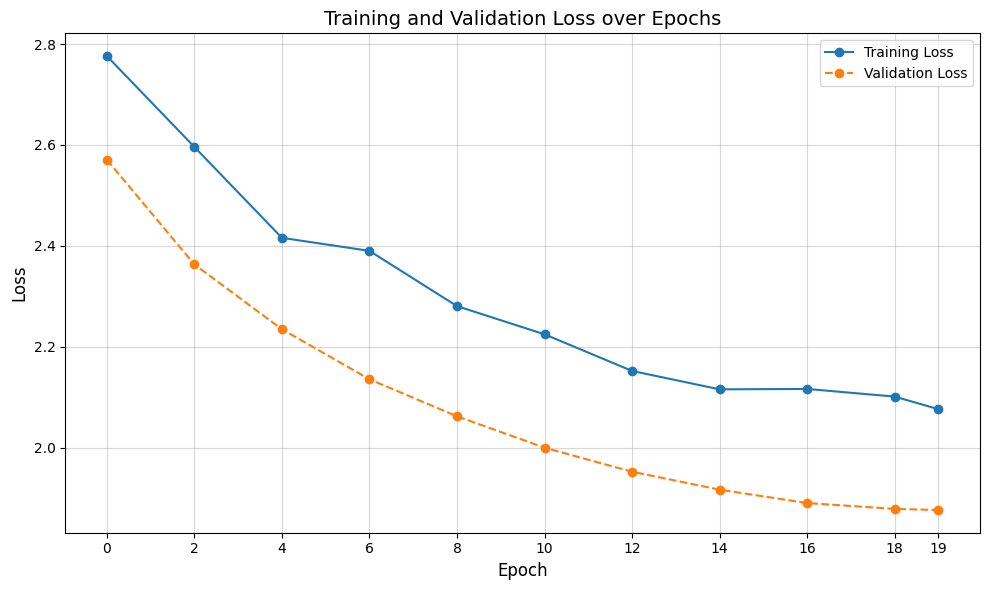

In [16]:
import matplotlib.pyplot as plt

# Data
epochs = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 19]
training_loss = [2.776300, 2.596000, 2.415900, 2.390000, 2.280500, 2.224600, 2.152000, 2.115500, 2.116300, 2.101100, 2.076200]
validation_loss = [2.570680, 2.363156, 2.234687, 2.135426, 2.062118, 1.999861, 1.952150, 1.916655, 1.890050, 1.878517, 1.876247]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o', linestyle='--')
plt.title('Training and Validation Loss over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(epochs)
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()

# Show plot
plt.show()


In [18]:
pwd

'/kaggle/working'

In [19]:
ls -l

total 32
drwxr-xr-x 2 root root  4096 Dec 20 14:46 best_model/
drwxr-xr-x 4 root root  4096 Dec 20 14:44 bio_bart_summarizer/
drwxr-xr-x 2 root root  4096 Dec 20 05:30 logs/
-rw-r--r-- 1 root root 17477 Dec 20 14:46 loss_curve.png


/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [20]:
ls -l best_model

total 548156
-rw-r--r-- 1 root root      1716 Dec 20 14:46 config.json
-rw-r--r-- 1 root root       264 Dec 20 14:46 generation_config.json
-rw-r--r-- 1 root root    456318 Dec 20 14:46 merges.txt
-rw-r--r-- 1 root root 557912620 Dec 20 14:46 model.safetensors
-rw-r--r-- 1 root root       957 Dec 20 14:46 special_tokens_map.json
-rw-r--r-- 1 root root      1239 Dec 20 14:46 tokenizer_config.json
-rw-r--r-- 1 root root   2108907 Dec 20 14:46 tokenizer.json
-rw-r--r-- 1 root root      5176 Dec 20 14:46 training_args.bin
-rw-r--r-- 1 root root    798293 Dec 20 14:46 vocab.json


In [21]:
!zip -r working_files.zip /kaggle/working/*


  adding: kaggle/working/best_model/ (stored 0%)
  adding: kaggle/working/best_model/generation_config.json (deflated 43%)
  adding: kaggle/working/best_model/vocab.json (deflated 59%)
  adding: kaggle/working/best_model/merges.txt (deflated 53%)
  adding: kaggle/working/best_model/training_args.bin (deflated 51%)
  adding: kaggle/working/best_model/tokenizer.json (deflated 72%)
  adding: kaggle/working/best_model/config.json (deflated 63%)
  adding: kaggle/working/best_model/model.safetensors (deflated 8%)
  adding: kaggle/working/best_model/special_tokens_map.json (deflated 85%)
  adding: kaggle/working/best_model/tokenizer_config.json (deflated 75%)
  adding: kaggle/working/bio_bart_summarizer/ (stored 0%)
  adding: kaggle/working/bio_bart_summarizer/checkpoint-16805/ (stored 0%)
  adding: kaggle/working/bio_bart_summarizer/checkpoint-16805/trainer_state.json (deflated 82%)
  adding: kaggle/working/bio_bart_summarizer/checkpoint-16805/scheduler.pt (deflated 55%)
  adding: kaggle/wor

In [23]:
ls -l

total 3512468
drwxr-xr-x 2 root root       4096 Dec 20 14:46 best_model/
drwxr-xr-x 4 root root       4096 Dec 20 14:44 bio_bart_summarizer/
drwxr-xr-x 2 root root       4096 Dec 20 05:30 logs/
-rw-r--r-- 1 root root      17477 Dec 20 14:46 loss_curve.png
-rw-r--r-- 1 root root 3596728078 Dec 20 14:58 working_files.zip


In [24]:
!pip install pydrive


In [25]:
#

InvalidConfigError: Invalid client secrets file ('Error opening file', 'client_secrets.json', 'No such file or directory', 2)

In [28]:
ls -l

total 3512472
drwxr-xr-x 2 root root       4096 Dec 20 14:46 best_model/
drwxr-xr-x 4 root root       4096 Dec 20 14:44 bio_bart_summarizer/
drwxr-xr-x 4 root root       4096 Dec 20 15:13 data-for-clinical-note-summarizer/
drwxr-xr-x 2 root root       4096 Dec 20 05:30 logs/
-rw-r--r-- 1 root root      17477 Dec 20 14:46 loss_curve.png
-rw-r--r-- 1 root root 3596728078 Dec 20 14:58 working_files.zip


In [30]:
!pip install boto3


In [31]:
import os
#Hidden keysssssss.
os.environ['AWS_ACCESS_KEY_ID'] 
os.environ['AWS_SECRET_ACCESS_KEY']


In [34]:
local_file_path = '/kaggle/working/working_files.zip'

In [32]:
ls -l


total 3512472
drwxr-xr-x 2 root root       4096 Dec 20 14:46 best_model/
drwxr-xr-x 4 root root       4096 Dec 20 14:44 bio_bart_summarizer/
drwxr-xr-x 4 root root       4096 Dec 20 15:13 data-for-clinical-note-summarizer/
drwxr-xr-x 2 root root       4096 Dec 20 05:30 logs/
-rw-r--r-- 1 root root      17477 Dec 20 14:46 loss_curve.png
-rw-r--r-- 1 root root 3596728078 Dec 20 14:58 working_files.zip


In [35]:
import boto3

# Initialize a session using Amazon S3
s3 = boto3.client('s3')

# Define your S3 bucket name and the destination file name
bucket_name = 'bucket-name'
s3_file_name = 'model.zip'

s3.upload_file(local_file_path, bucket_name, s3_file_name)

print(f'File uploaded successfully to s3://{bucket_name}/{s3_file_name}')


File uploaded successfully to s3://abhaycontent/model.zip
